Monthly car sales in Quebec 1960-1968

<https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968>

In [110]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [111]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [112]:
cars_df = pd.read_csv("data/car_sales/monthly-car-sales-in-quebec-1960.csv")
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


Remove last row

In [113]:
cars_df = cars_df.iloc[:-1]

Let's change it into datetime format for nicer plots.

In [114]:
cars_df["dt"] = pd.to_datetime(cars_df["Month"])

Rename the long name in column `Monthly car sales in Quebec 1960-1968` for just `sales`.

In [115]:
cars_df = cars_df.rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)
cars_df.tail()

,Month,sales,dt
103,1968-08,16722.0,1968-08-01
104,1968-09,14385.0,1968-09-01
105,1968-10,21342.0,1968-10-01
106,1968-11,17180.0,1968-11-01
107,1968-12,14577.0,1968-12-01


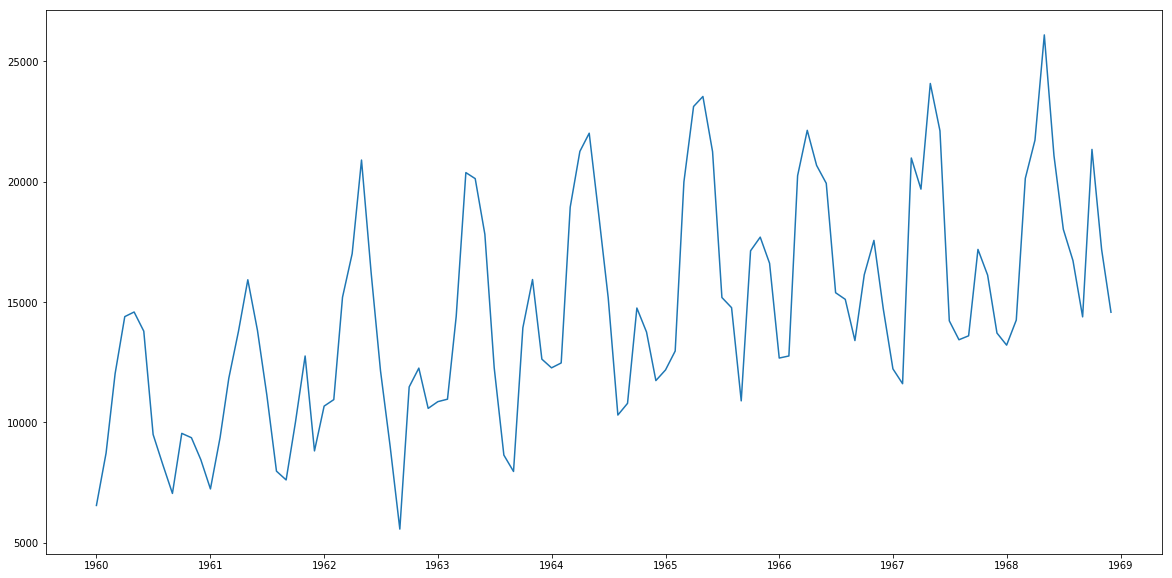

In [116]:
plt.plot(cars_df["dt"], cars_df["sales"])
plt.show()

Let's check if there is no missing data. For example, let's check if each year has 12 months.

In [117]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


## Train - dev - test split

Here we cannont do random spliting later we will explain why. Our split should be based on time.

In [118]:
Xy = cars_df[['dt', 'sales']]

def create_X_and_y(Xy, target_column='sales'):
    return Xy.drop(target_column, axis=1), Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy.query("dt < '1967'"))
    X_dev, y_dev = create_X_and_y(Xy.query("dt >= '1967' and dt < '1968'"))
    X_test, y_test = create_X_and_y(Xy.query("dt >= '1968'"))
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy)

## Simplest prediction: average of previous sales

In [119]:
y_dev_hat = np.ones(len(y_dev)) * y_train.mean()

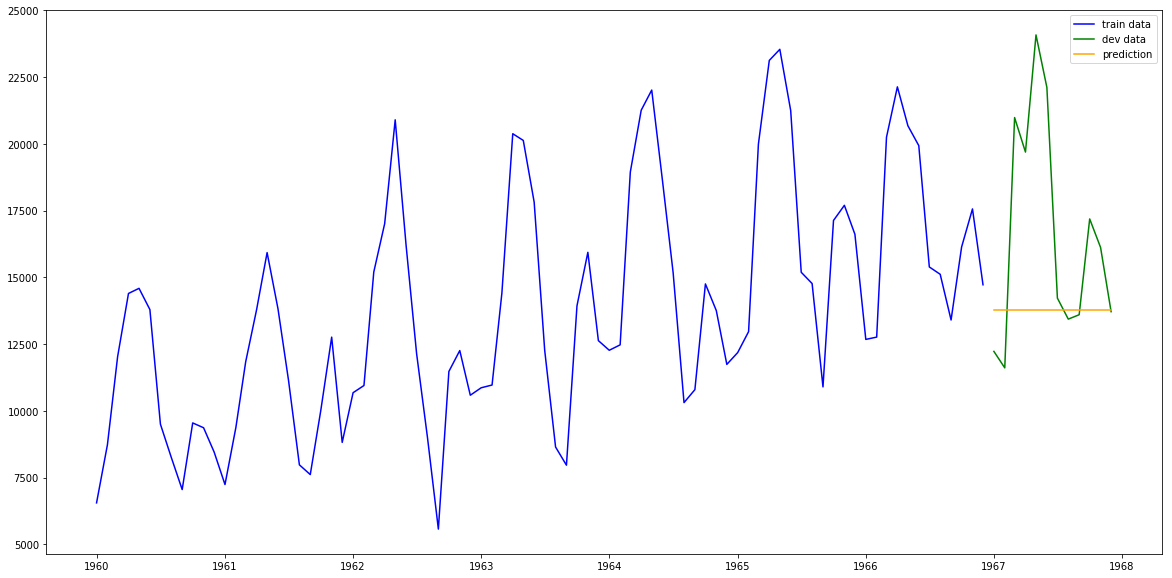

In [120]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

We see that this is not very good prediction. However, we will use it as our __baseline__, that is a starting point for further improvments. For that let's calculate mean square error (MSE) and root of mean square error (RMSE) which will serve us for comparation with better predictions.

In [121]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_dev, y_dev_hat), np.sqrt(mean_squared_error(y_dev, y_dev_hat))

(23847172.57993197, 4883.356691859808)

## Average of the previous year

So let's take the last 12 values and calculate mean.

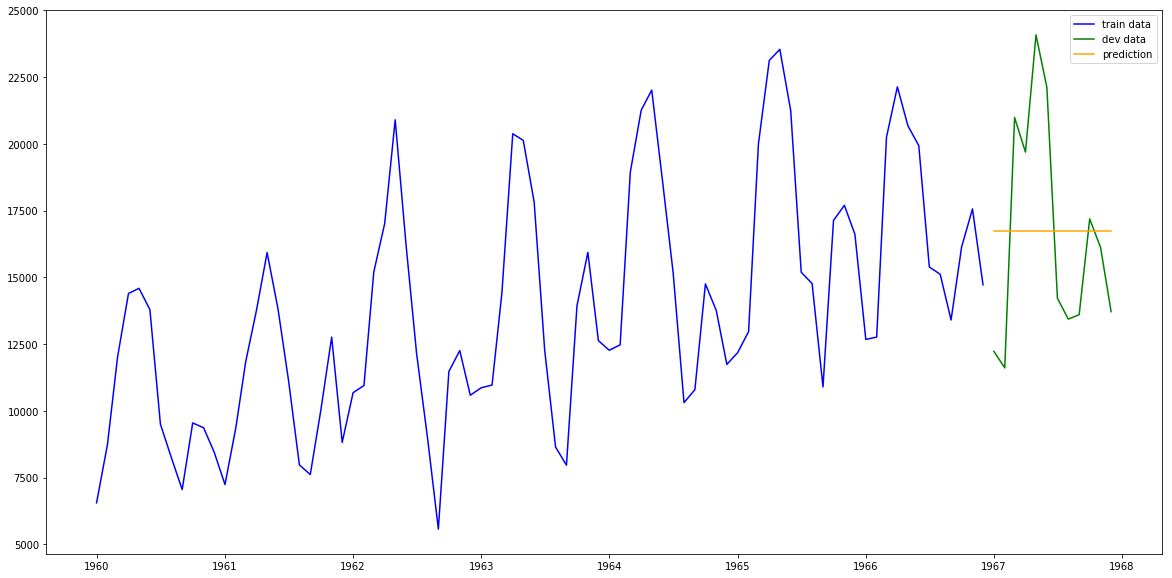

In [122]:
y_dev_hat = np.ones(len(y_dev)) * y_train[-12:].mean()
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

This time it looks better.

In [123]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4011.3046791744287

So we have also improved RMSE.

## Taking advantage of knowing previous month

Often, we know the value for the previous month and we want to predict just the next month. For this we add to our feature set $X$ the value of the prevous month. For that we have python method `shift`.

In [124]:
Xy_with_lags = Xy.copy()
Xy_with_lags['sales-1'] = Xy_with_lags['sales'].shift(1)
Xy_with_lags.head()

,dt,sales,sales-1
0,1960-01-01,6550.0,NaN
1,1960-02-01,8728.0,6550.0
2,1960-03-01,12026.0,8728.0
3,1960-04-01,14395.0,12026.0
4,1960-05-01,14587.0,14395.0


In [125]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

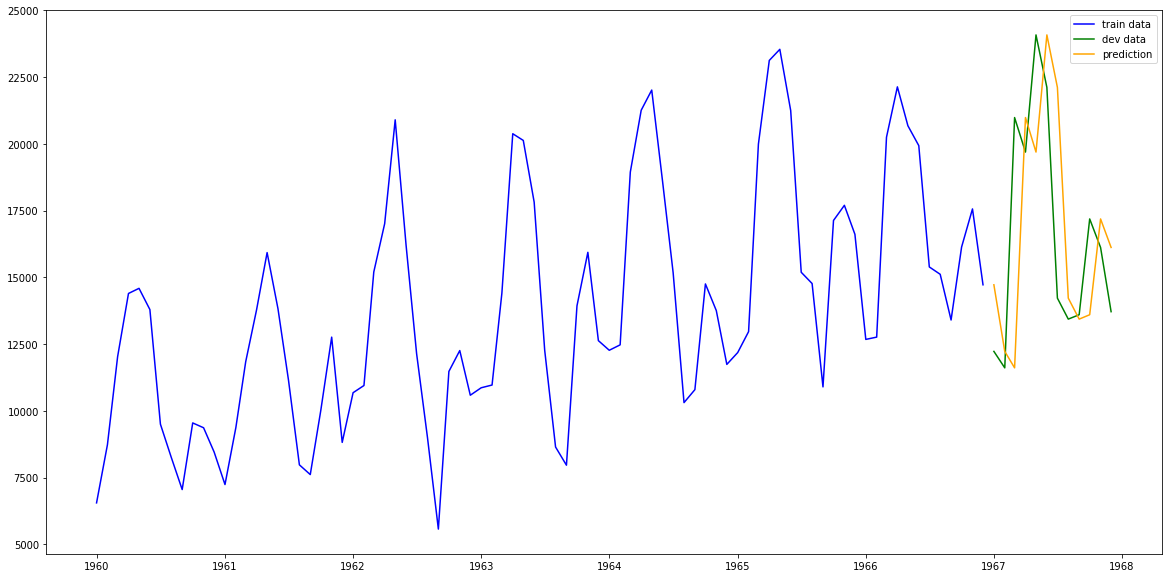

In [126]:
y_dev_hat = X_dev['sales-1']
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [127]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4103.945367976203

## Moving average

Now let's add previous 12 months.

In [129]:
for i in range(1, 13):
    Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
Xy_with_lags.tail()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
103,1968-08-01,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,13434.0
104,1968-09-01,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0
105,1968-10-01,21342.0,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0
106,1968-11-01,17180.0,21342.0,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0
107,1968-12-01,14577.0,17180.0,21342.0,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0


In [130]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

Let's take its mean. This is called __moving average__.

In [131]:
columns_for_mean = ["sales-" + str(i) for i in range(1, 13)]
y_dev_hat = X_dev[columns_for_ar].mean(axis=1)

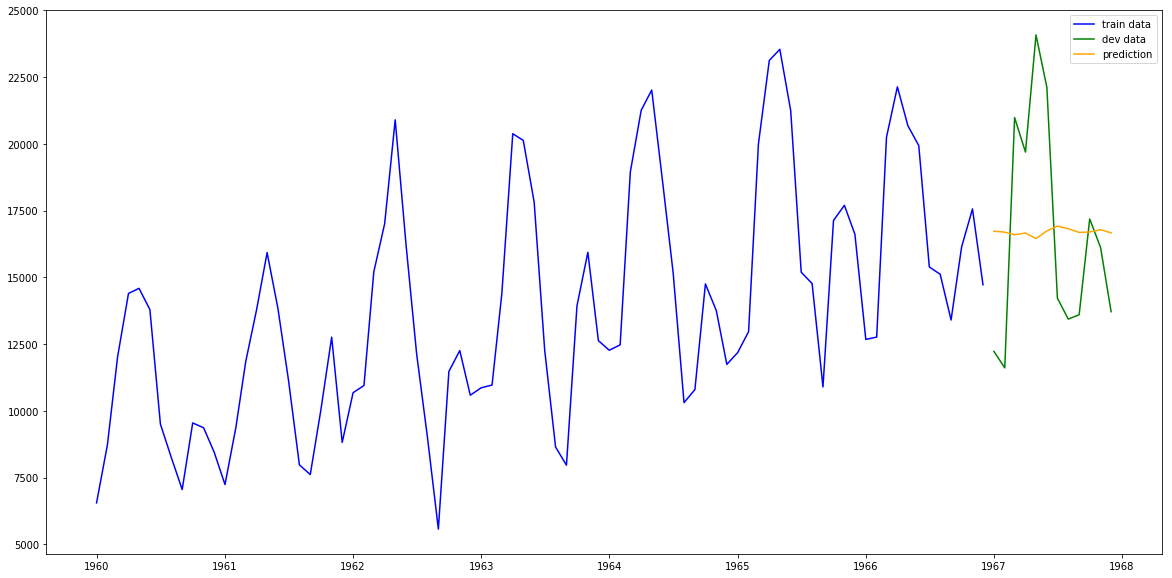

In [132]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [133]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4076.0106450249227

## Auto Regression (AR)

At the begning of our dataser we have lots of `NaN`s. Let's remove them.

In [135]:
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1960-01-01,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-04-01,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960-05-01,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
Xy_with_lags = Xy_with_lags.query("dt > '1961'")
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
13,1961-02-01,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
14,1961-03-01,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
15,1961-04-01,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
16,1961-05-01,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0
17,1961-06-01,13821.0,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0


In [138]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
columns_for_ar = ["sales-" + str(i) for i in range(1, 13)]

reg.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = reg.predict(X_dev.drop("dt", axis=1))
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1998.6061539258658

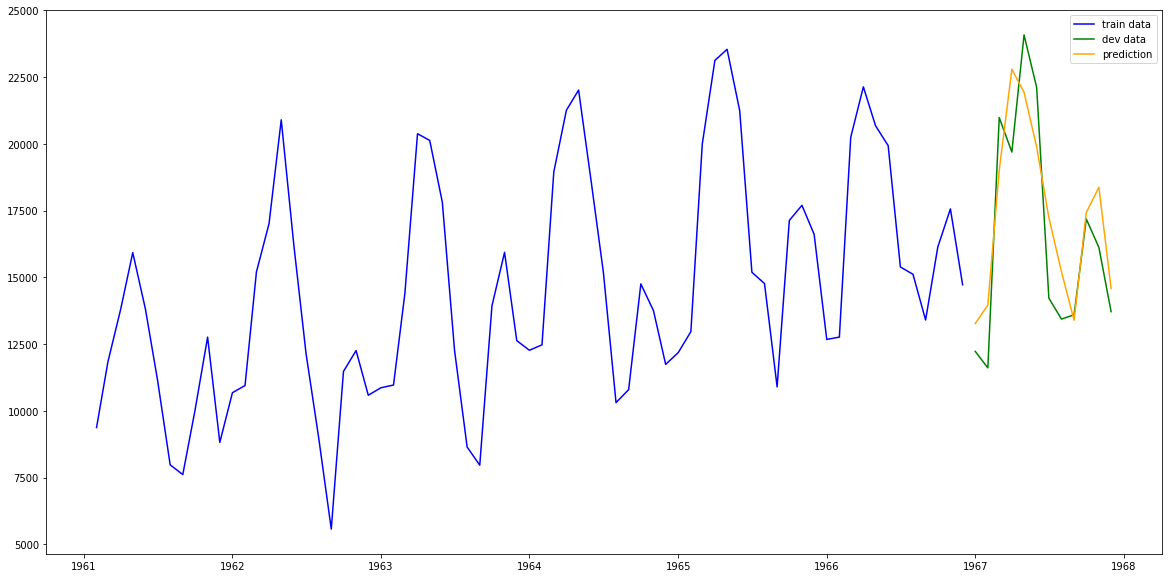

In [139]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

We have improved the performance twice!

In [ ]:
from statsmodels.tsa.ar_model import 

## Bibliography

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc41.htm

https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf